# Building machine learning models

Let's build our first basic models for mortality prediction & predicting the hospital length of stay! We previously explored the rich content of the MIMIC database, extracted and preprocessed data so that we could use them in a classifier. Now, we'll build a model for these prediction tasks and evaluate them.

For mortality prediction, which is a binary classification problem, we'll experiment with logistic regression, support, decision trees and random forests.

Hospital length of stay is a regression problem, hence we will use least squares regression and linear ridge regression from the Shogun toolbox.

In [65]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from scipy.stats import ks_2samp
from modshogun import *

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')


In [2]:
# SQL database config
sqluser = ''
dbname = 'MIMIC3'
schema_name = 'mimiciii'
hostname = ''
port = 5432
pwd = getpass.getpass()

········


In [35]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=5432, password=pwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [120]:
query = \
"""
-- Table #3: Services
with serv AS
(
SELECT icu.hadm_id, icu.icustay_id, se.curr_service
, CASE
    WHEN curr_service like '%SURG' then 1
    WHEN curr_service = 'ORTHO' then 1
    ELSE 0 END
  as surgical
, RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
FROM icustays icu
LEFT JOIN services se
 ON icu.hadm_id = se.hadm_id
AND se.transfertime < icu.intime + interval '12' hour
)

-- Table #4: Clinical data + demographics
, co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, first_careunit, admission_type
, icu.los as icu_los
, round((EXTRACT(EPOCH FROM (adm.dischtime-adm.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age_icu_in
, pat.gender
, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
, hospital_expire_flag
, CASE WHEN pat.dod IS NOT NULL 
       AND pat.dod >= icu.intime - interval '6 hour'
       AND pat.dod <= icu.outtime + interval '6 hour' THEN 1 
       ELSE 0 END AS icu_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '30' day THEN 1 
    ELSE 0 END as hospital30day_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '1' year THEN 1 
    ELSE 0 END as hospital1year_expire_flag      
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
INNER JOIN admissions adm
ON adm.hadm_id = icu.hadm_id    
)

-- Table #5: Exclusions
, excl AS
(
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_los, co.hosp_los
  , co.age_icu_in
  , co.gender
  , co.icustay_id_order
  , serv.curr_service
  , co.first_careunit
  , co.hospital_expire_flag
  , co.icu_expire_flag
  , CASE
        WHEN co.icu_los < 1 then 1
    ELSE 0 END
    AS exclusion_los
  , CASE
        WHEN co.age_icu_in < 16 then 1
    ELSE 0 END
    AS exclusion_age
  , CASE 
        WHEN co.icustay_id_order != 1 THEN 1
    ELSE 0 END 
    AS exclusion_first_stay
  , CASE
        WHEN serv.surgical = 1 THEN 1
    ELSE 0 END
    as exclusion_surgical
FROM co
LEFT JOIN serv
  ON  co.icustay_id = serv.icustay_id
  AND serv.rank = 1
)

SELECT vital.icustay_id, vital.subject_id, vital.hadm_id
-- vital signs for the first 24 hours of the icu stay
, HeartRate_Min
, HeartRate_Mean
, HeartRate_Max
, DiasBP_Min
, DiasBP_Max
, SysBP_Min
, SysBP_Max
, MeanBP_Min
, MeanBP_Mean
, MeanBP_Max
, RespRate_Min
, RespRate_Mean
, RespRate_Max
, TempC_Min
, TempC_Max
, SpO2_Min
, SpO2_Max

-- Glasgow coma score
, MinGCS
, GCSMotor
, GCSVerbal
, GCSEyes

-- lab values
, ANIONGAP_min
, ANIONGAP_max
, ALBUMIN_min
, ALBUMIN_max
, BANDS_min
, BANDS_max
, BICARBONATE_min
, BICARBONATE_max
, BILIRUBIN_min
, BILIRUBIN_max
, CREATININE_min
, CREATININE_max
, CHLORIDE_min
, CHLORIDE_max
, lab.GLUCOSE_min
, lab.GLUCOSE_max
, HEMATOCRIT_min
, HEMATOCRIT_max
, HEMOGLOBIN_min
, HEMOGLOBIN_max
, LACTATE_min
, LACTATE_max
, PLATELET_min
, PLATELET_max
, POTASSIUM_min
, POTASSIUM_max
, PTT_min
, PTT_max
, INR_min
, INR_max
, PT_min
, PT_max
, SODIUM_min
, SODIUM_max
, BUN_min
, BUN_max
, WBC_min
, WBC_max

, urineoutput

-- whether the patient is ventilated on the first day of the ICU stay
, vent

-- demographic data
, co.age_icu_in, co.first_careunit, co.gender, co.admission_type
, hw.height_first, hw.weight_first

-- outcomes
, co.hospital_expire_flag, co.icu_expire_flag
, co.hosp_los, co.icu_los, co.icustay_id_order
, co.hospital1year_expire_flag, hospital30day_expire_flag

-- exclusions
, excl.exclusion_los, excl.exclusion_age
, excl.exclusion_first_stay, excl.exclusion_surgical

FROM mimiciii_dev.vitalsfirstday vital
LEFT JOIN mimiciii_dev.labsfirstday lab
  ON vital.icustay_id = lab.icustay_id
LEFT JOIN mimiciii_dev.gcsfirstday gcs
  ON vital.icustay_id = gcs.icustay_id
LEFT JOIN mimiciii_dev.uofirstday uo
  ON vital.icustay_id = uo.icustay_id
LEFT JOIN mimiciii_dev.ventfirstday vent
  ON vital.icustay_id = vent.icustay_id
left join co
  ON vital.icustay_id = co.icustay_id
left join public.heightweight hw
  ON vital.icustay_id = hw.icustay_id
left join excl
  on vital.icustay_id = excl.icustay_id;
"""

query_output = pd.read_sql_query(query,con) #.dropna().reset_index(drop=True)
query_output.head()

,icustay_id,subject_id,hadm_id,heartrate_min,heartrate_mean,heartrate_max,diasbp_min,diasbp_max,sysbp_min,sysbp_max,...,icu_expire_flag,hosp_los,icu_los,icustay_id_order,hospital1year_expire_flag,hospital30day_expire_flag,exclusion_los,exclusion_age,exclusion_first_stay,exclusion_surgical
0,263738,13,143045,60.0,83.600000,124.0,53.0,84.0,102.0,151.0,...,0,6.8556,3.6660,1,0,0,0,0,0,0
1,211832,71,111944,98.0,112.444444,137.0,31.0,130.0,94.0,157.0,...,0,4.6618,2.8609,1,0,0,0,0,0,0
2,233150,78,100536,56.0,63.117647,73.0,78.0,119.0,134.0,206.0,...,0,3.9139,1.4891,1,0,0,0,0,0,0
3,233111,101,175533,72.0,87.034483,117.0,19.0,85.0,57.0,182.0,...,0,15.7785,9.8919,1,1,1,0,0,0,0
4,212246,103,130744,42.0,51.500000,60.0,40.0,71.0,112.0,161.0,...,0,7.7347,3.0237,1,1,1,0,0,0,1


In [128]:
query_output.describe()

,hospital_expire_flag,icu_expire_flag,hosp_los,icu_los,hospital1year_expire_flag,hospital30day_expire_flag,age_icu_in,gender,first_careunit,heartrate_min,...,bilirubin_min,bilirubin_max,creatinine_min,creatinine_max,hemoglobin_min,hemoglobin_max,sodium_min,sodium_max,wbc_min,wbc_max
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
query_output.to_csv('./full-features-materialized.csv', index=False)

## First lab measurement visualization

To get a better idea of how laboratory measurements for patients admitted to the ICU, we'll plot the distribution of measurements for survival and non-survival groups.

In [56]:
# Create dictionary of ranges
# Keys should match the lab names in the query below
# Are these values correct given the units? Need to check.

lab_ranges = {'BICARBONATE': [22,32],
              'BUN': [6,20],
              'CALCIUM': [8.4,10.3],
              'CHLORIDE': [96,108],
              'CREATININE': [0.4,1.1],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145]
             }

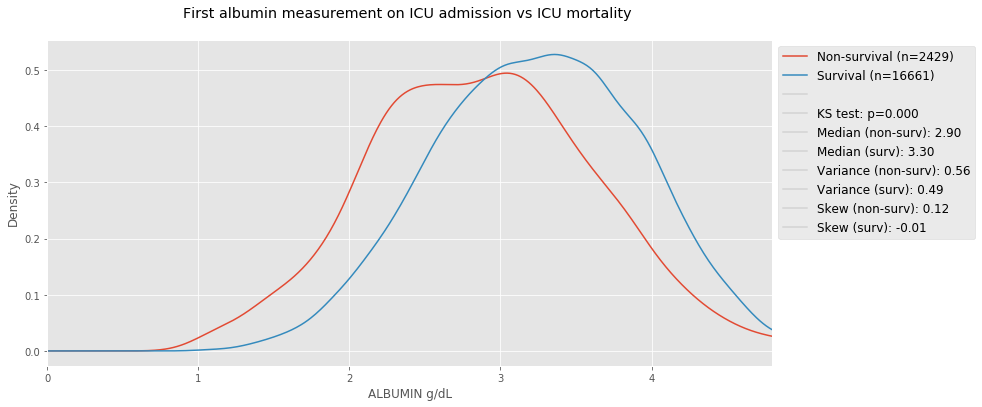

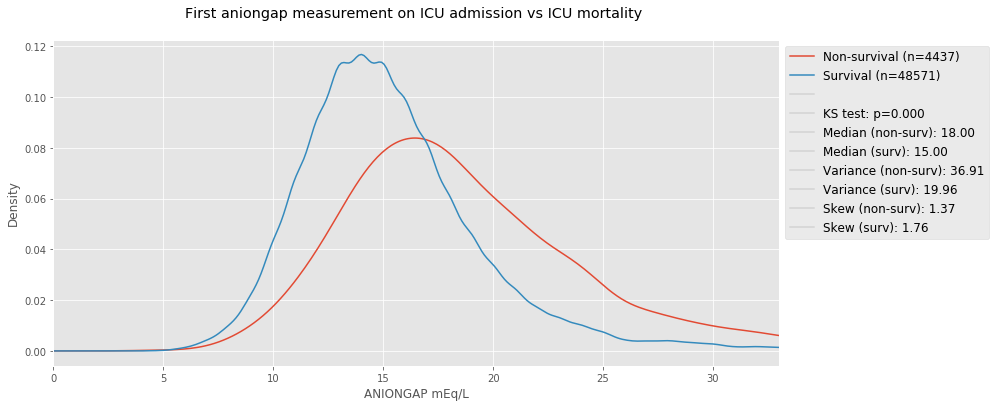

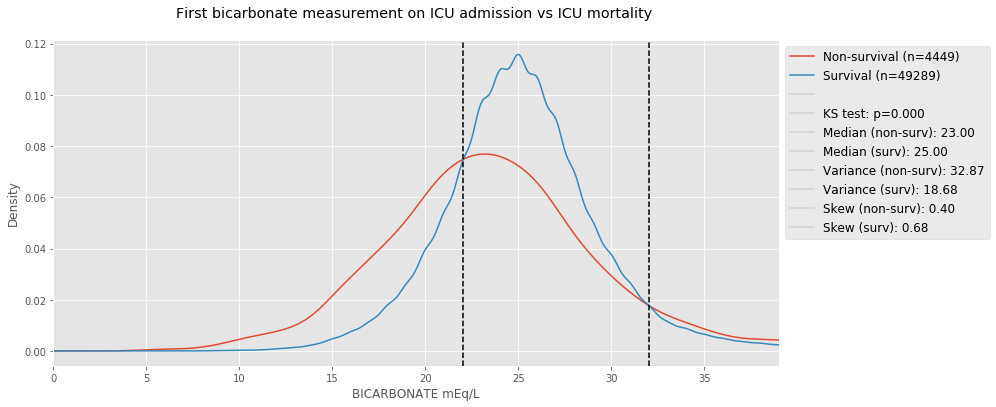

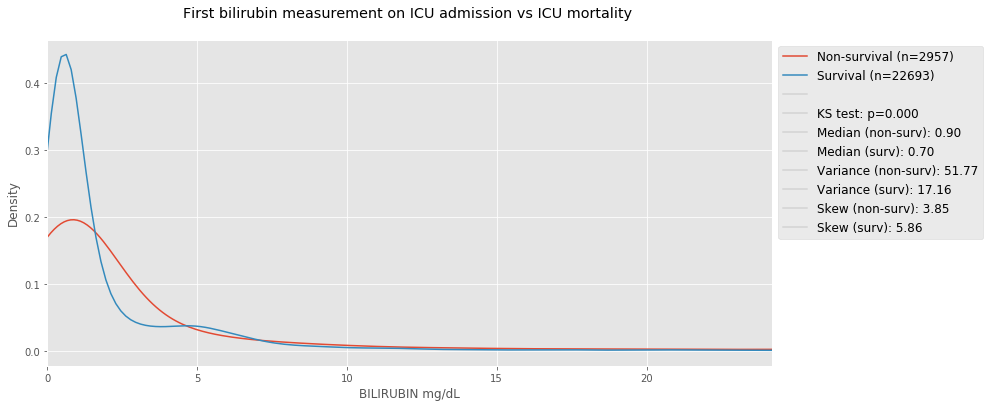

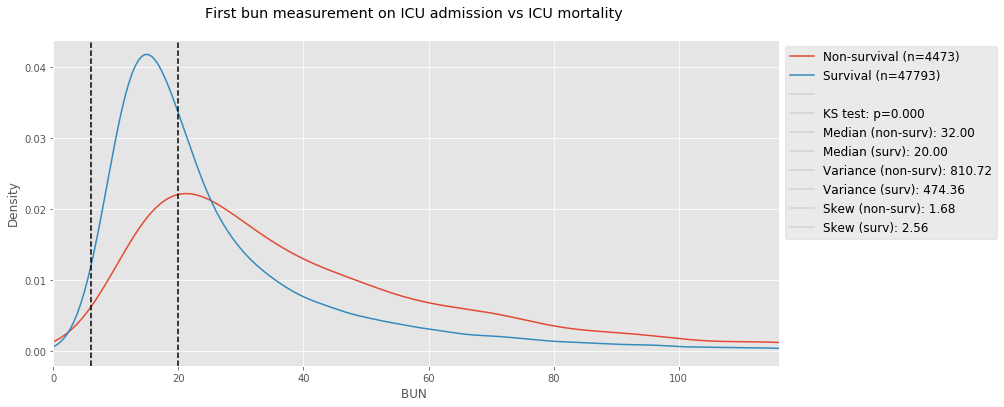

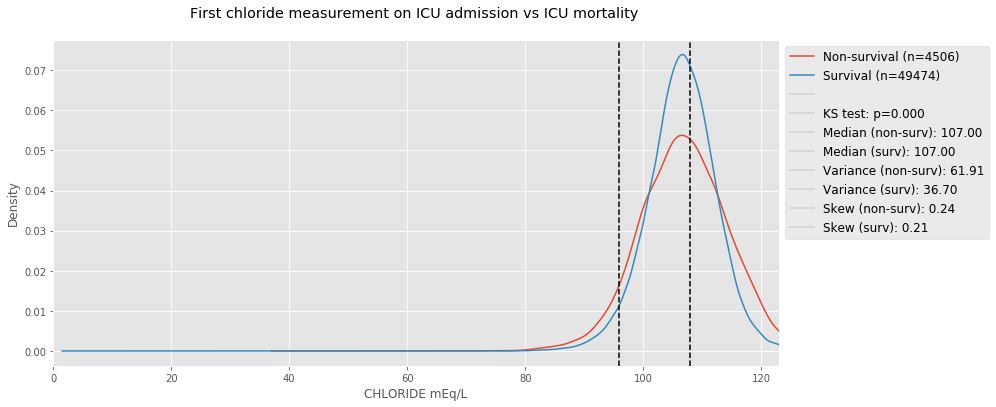

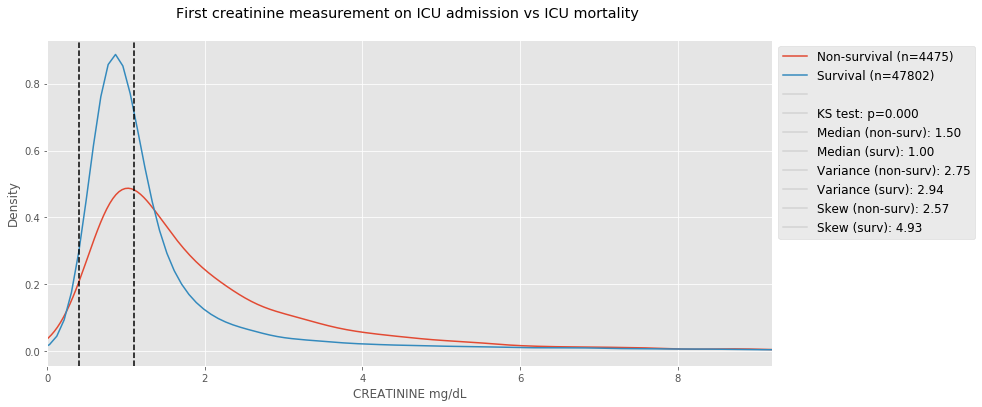

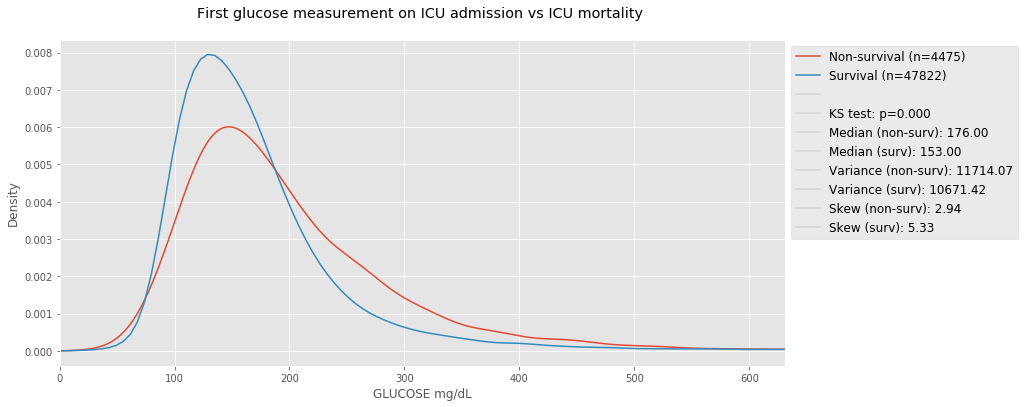

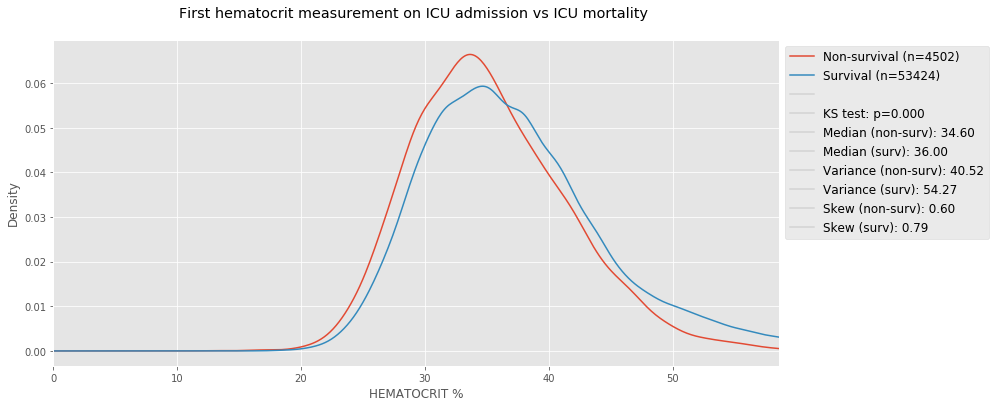

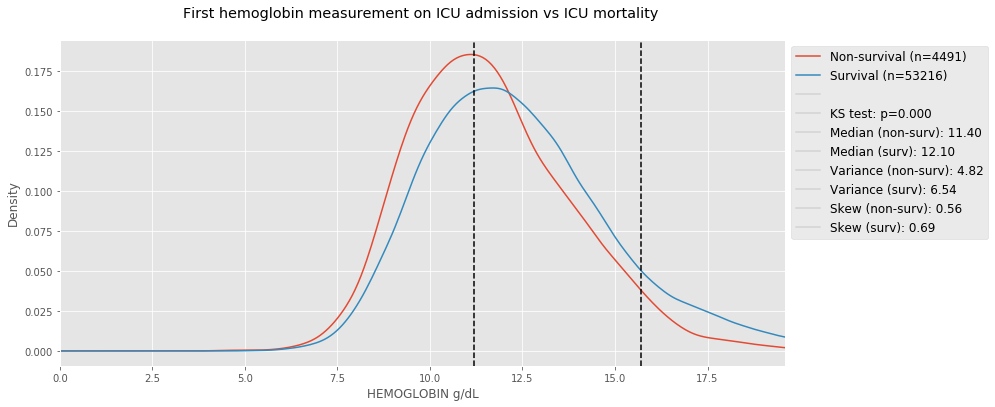

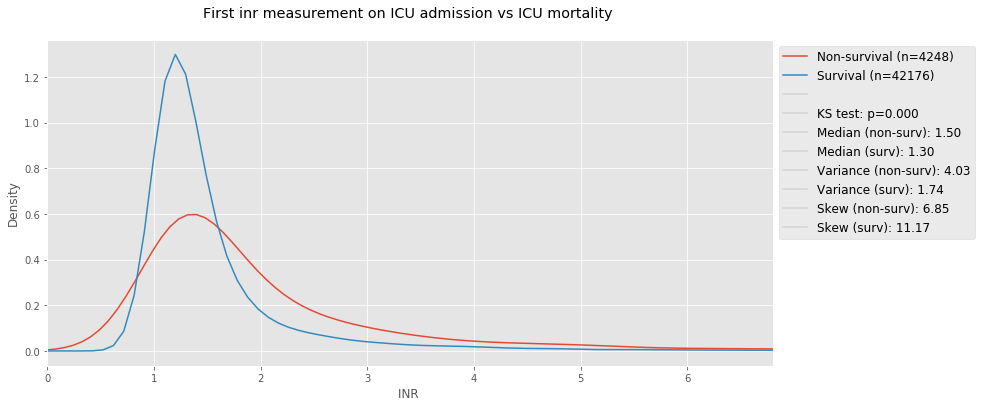

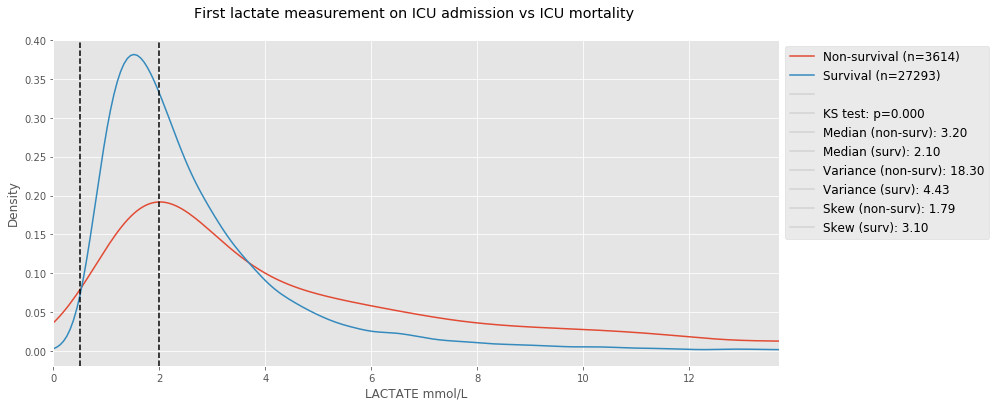

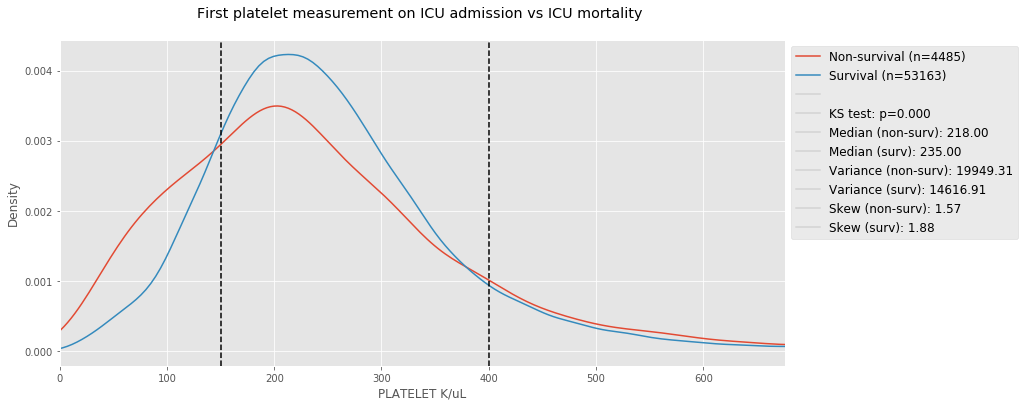

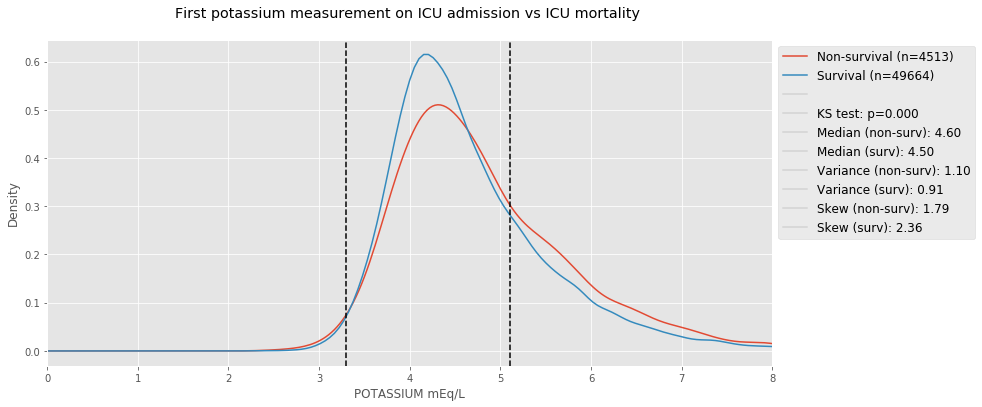

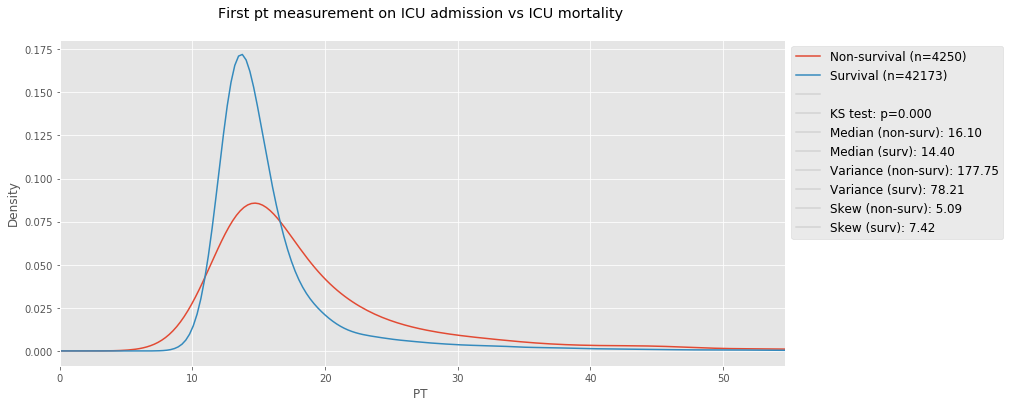

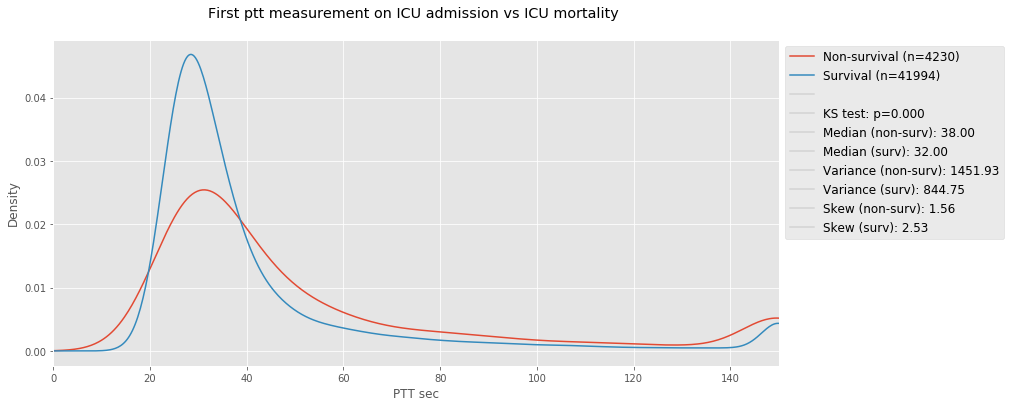

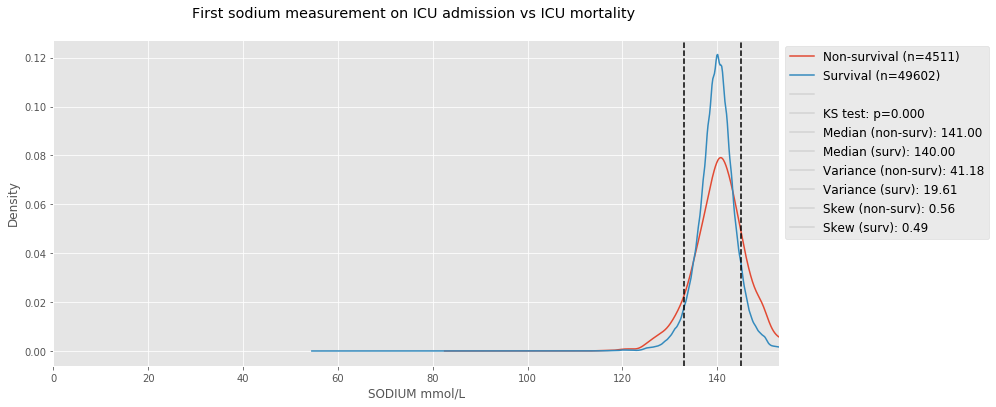

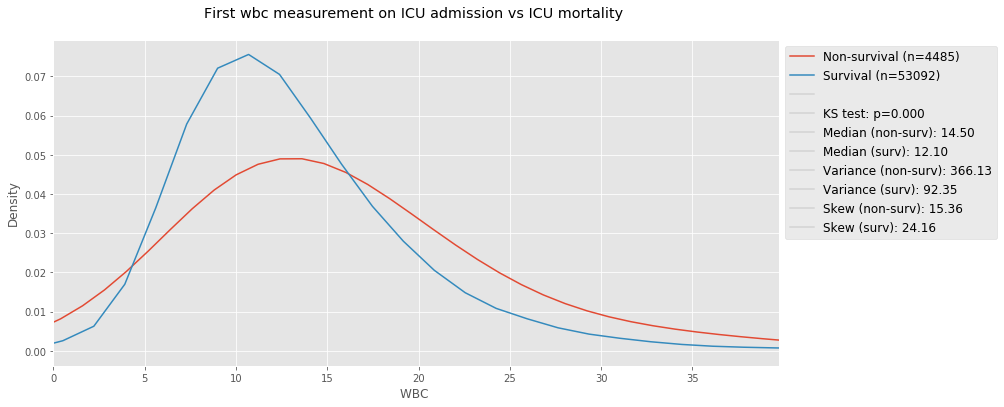

In [73]:
labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}

data = query_output

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().count()
    n_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().median()
    med_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().median()
    var_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().var()
    var_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().var()
    skew_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().skew()
    skew_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l.lower()+'_max'][data.icu_expire_flag==1].dropna(),
                              data[l.lower()+'_max'][data.icu_expire_flag==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, data[l.lower()+'_max'].quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

## Mortality prediction

In [169]:
query_output = pd.read_csv('./full-features-materialized.csv') #.dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) & (query_output.exclusion_first_stay == 0)]

outcome_names = ['hospital_expire_flag', 'icu_expire_flag', 
                 'hosp_los', 'icu_los', 'hospital1year_expire_flag', 
                 'hospital30day_expire_flag']

feature_names = [
            # Demographic information
            'age_icu_in', 'gender', 'first_careunit', 
    
            # Vital signs
            'heartrate_min', 'heartrate_max', 
            'meanbp_min', 'meanbp_max', 
            'diasbp_min', 'diasbp_max',
            'sysbp_min', 'sysbp_max',
            'resprate_min', 'resprate_max',
            'mingcs', 'gcsmotor',
            'gcsverbal', 'gcseyes',             
            'tempc_min', 'tempc_max',
            'spo2_min', 'spo2_max',
                 
            # Laboratory measurements
            'aniongap_min', 'aniongap_max',
            #'albumin_min', 'albumin_max',
            #'bands_min', 'bands_max',
            'bicarbonate_min', 'bicarbonate_max',
            'bilirubin_min', 'bilirubin_max',
            'creatinine_min', 'creatinine_max',
            'chloride_min', 'chloride_max',
            'glucose_min', 'glucose_max',
            'hematocrit_min', 'hematocrit_max',
            'hemoglobin_min', 'hemoglobin_max',
            #'lactate_min', 'lactate_max',
            'platelet_min', 'platelet_max',
            'potassium_min', 'potassium_max',
            #'ptt_min', 'ptt_max',
            #'inr_min', 'inr_max',
            #'pt_min', 'pt_max',
            'sodium_min', 'sodium_max',
            'bun_min', 'bun_max',
            'wbc_min', 'wbc_max',                 
                 
            # Other
            'vent', 
            'urineoutput'
            ]

query_output = query_output.loc[:, outcome_names + feature_names].dropna().reset_index(drop=True)

outcomes = query_output.loc[:, outcome_names]
features = query_output.loc[:, query_output.columns.difference(outcome_names)]

X = features
y = outcomes['hospital_expire_flag'].replace(0, -1)

print(len(query_output))
query_output.tail()

13526


,hospital_expire_flag,icu_expire_flag,hosp_los,icu_los,hospital1year_expire_flag,hospital30day_expire_flag,age_icu_in,gender,first_careunit,heartrate_min,...,potassium_min,potassium_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,vent,urineoutput
13521,0,0,46.8493,5.0221,0,0,60.621797,1,5,79.0,...,3.7,4.8,135.0,144.0,13.0,16.0,5.7,12.7,1,1458.0
13522,0,0,10.4208,4.8565,0,0,66.826330,1,2,84.0,...,3.7,4.1,139.0,140.0,14.0,20.0,11.4,12.5,0,4425.0
13523,0,0,3.1743,3.1737,0,0,63.893494,0,2,60.0,...,3.5,3.9,139.0,143.0,16.0,31.0,5.3,8.6,0,1400.0
13524,0,0,2.2396,1.2625,0,0,43.594414,0,0,58.0,...,3.8,4.1,139.0,140.0,12.0,13.0,11.7,11.8,0,1250.0
13525,1,1,9.0653,9.1439,1,1,86.957864,1,2,52.0,...,5.0,5.7,123.0,128.0,41.0,42.0,11.4,13.3,1,730.0


In [170]:
split = int(len(X) * 0.7)

X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = BinaryLabels(np.array(y[:split]))
y_test = BinaryLabels(np.array(y[split:]))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

('Number of training samples:', 9468)
('Number of testing samples:', 4058)


In [171]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train)
svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply(X_test)

#use AccuracyMeasure to get accuracy
acc = AccuracyMeasure()
acc.evaluate(y_pred, y_test)

accuracy = acc.get_accuracy() * 100
print('Accuracy(%):', accuracy)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test)

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Accuracy(%):', 86.10152784622967)
('Area under ROC(%):', 0.8214451640664556)
CPU times: user 2.59 s, sys: 3.05 s, total: 5.64 s
Wall time: 1.93 s


## Length of stay